In [1]:
%matplotlib notebook

In [2]:
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np

import itertools
import math
import os

In [3]:
# Distances

def distance(a, b):
    diff = a - b
    exp = np.power(diff, 2)
    agg = np.sum(exp)
    root = np.sqrt(agg)
    return root

def alldistance(z):
    zdiff = z.reshape(-1, 1, 2) - z.reshape(1, -1, 2)
    zexp = np.power(zdiff, 2)
    zagg = np.sum(zexp, 2)
    zroot = np.sqrt(zagg)
    return zroot

# Shortest Path (by heuristic)

def nextclosest_helper(point, point_index, endindex, z, zdist, mindist=0.2):
    end = z[endindex]

    xstart = point[0]
    xend = end[0]
    dist = zdist[point_index]
    edist = zdist[:, endindex]
    mydist = zdist[point_index, endindex]
    
#     print(mindist)
    
    index = np.arange(z.shape[0])
    mask = np.logical_and(z[:, 0] >= xstart, dist >= 0)
    mask = np.logical_and(mask, dist >= mindist)
#     mask = np.logical_and(mask, z[:, 0] <= xend)
    mask = np.logical_and(mask, edist <= mydist)
    
    dmask = dist[mask]
    imask = index[mask]
    
    argmin = np.argmin(dmask)

    return imask[argmin]

def nextclosest(point, point_index, endindex, z, zdist, mindist=0.3, ntries=3):
    __mindist = mindist
    closest = None
    for i in range(ntries):
        try:
            closest = nextclosest_helper(point, point_index, endindex, z, zdist, mindist=__mindist)
        except:
            __mindist = mindist - (mindist / ntries) * (i+1)
    return closest

def heuristic_path(startindex, endindex, z, zdist, mindist=0.3, noise_scale=math.inf, eps=1e-8):
    start = z[startindex]
    end = z[endindex]

    closest = start
    nextindex = 0
    pathindex = [nextindex]

    count = 0

    for _ in tqdm(itertools.repeat(None)):
        noise = np.random.normal(size=1, scale=mindist/noise_scale)
        __mindist = mindist + noise

        prevclosest = closest
        
        nextindex = nextclosest(closest, nextindex, endindex, z, zdist, mindist=__mindist)
        
        if nextindex is None:
            nextindex = endindex
        
        closest = z[nextindex]
        prev2now = distance(prevclosest, closest)
        prev2end = distance(prevclosest, end)

        if prev2now + eps >= prev2end:
            nextindex = endindex
            closest = end
        
        pathindex.append(nextindex)
        
        if nextindex == endindex:
            break

        count += 1

        if count > z.shape[0]:
            raise RuntimeError('Loop did not terminate.')

    path = z[pathindex]
    
    return path

def sample_points():
    # State

    np.random.seed(11)

    # Config

    xdim = 10
    ydim = 1
    n = 2000

    start = np.array([-3, 0])
    end = np.array([3, 0])
    loc = (start[0] + end[0]) / 2
    scale = end[0]

    # Generate Points

    xs = np.random.normal(size=n, loc=loc, scale=scale)
    ys = np.random.normal(size=n) * ydim

    ys = np.array([y for x, y in zip(xs, ys) if x > start[0] and x < end[0]])
    xs = np.array([x for x in xs if x > start[0] and x < end[0]])

    z = np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1)
    z = np.concatenate([start.reshape(1, 2), z, end.reshape(1, 2)], axis=0)
    
    return z

def generate_track(z, start_index=None, end_index=None, mindist=0.6, noise_scale=10):
    """
    mindist = 0.6
    noise_scale = 10  # use math.inf to ignore
    """
    
    if start_index is None:
        print('setting start_index')
        start_index = 0
    if end_index is None:
        print('setting end_index')
        end_index = z.shape[0] - 1
    
    start = z[start_index]
    end = z[end_index]

    zdist = alldistance(z)

    path = heuristic_path(start_index, end_index, z, zdist, mindist=mindist, noise_scale=noise_scale)

    print('Path Length = {}'.format(path.shape[0]))
    
    return path

def visualize(z, path):
    # Visualize

    plt.figure()

    plt.scatter(z[:, 0], z[:, 1], color='y')
    plt.plot(path[:, 0], path[:, 1], color='g')
    plt.scatter(path[1:-1, 0], path[1:-1, 1], color='g')
    plt.scatter([path[0, 0], path[-1, 0]], [path[0, 1], path[-1, 1]], color='orange')

    plt.axis('equal')

    plt.show()

setting start_index
setting end_index



Path Length = 16


<IPython.core.display.Javascript object>


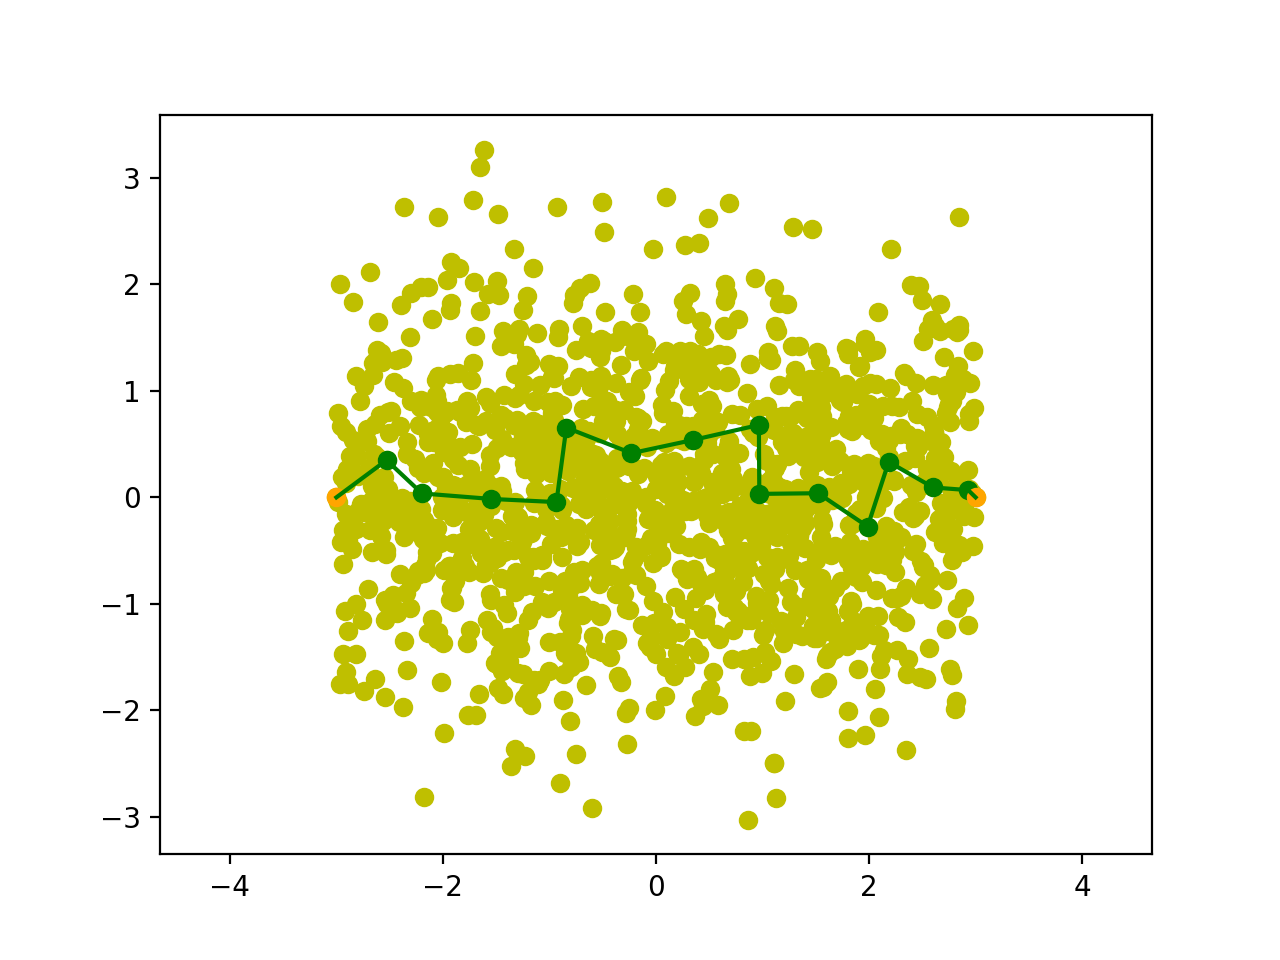

In [4]:
z = sample_points()
path = generate_track(z=z)
visualize(z, path)

In [5]:
def read_csv(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            parts = line.split('|')
            lat, lon, name = float(parts[2]), float(parts[3]), parts[4]
            points.append((lat, lon, name))
    return points

In [6]:
# https://www.openstreetmap.org/export#map=12/40.8504/-73.8817
# extracted POIs: https://github.com/MorbZ/OsmPoisPbf
# convert osm to pbf using osmosis (brew install osmosis)
# 
# osmosis --read-xml file="big-map.osm" --write-pbf file="big-map.osm.pbf"
# java -Xmx4g -jar osmpois.jar big-map.osm.pbf
#
filename = os.path.expanduser('~/Downloads/big-map.csv')
points = read_csv(filename)

In [7]:
limit = 2000

lats, lons, names = zip(*points[:limit])

2000


<IPython.core.display.Javascript object>


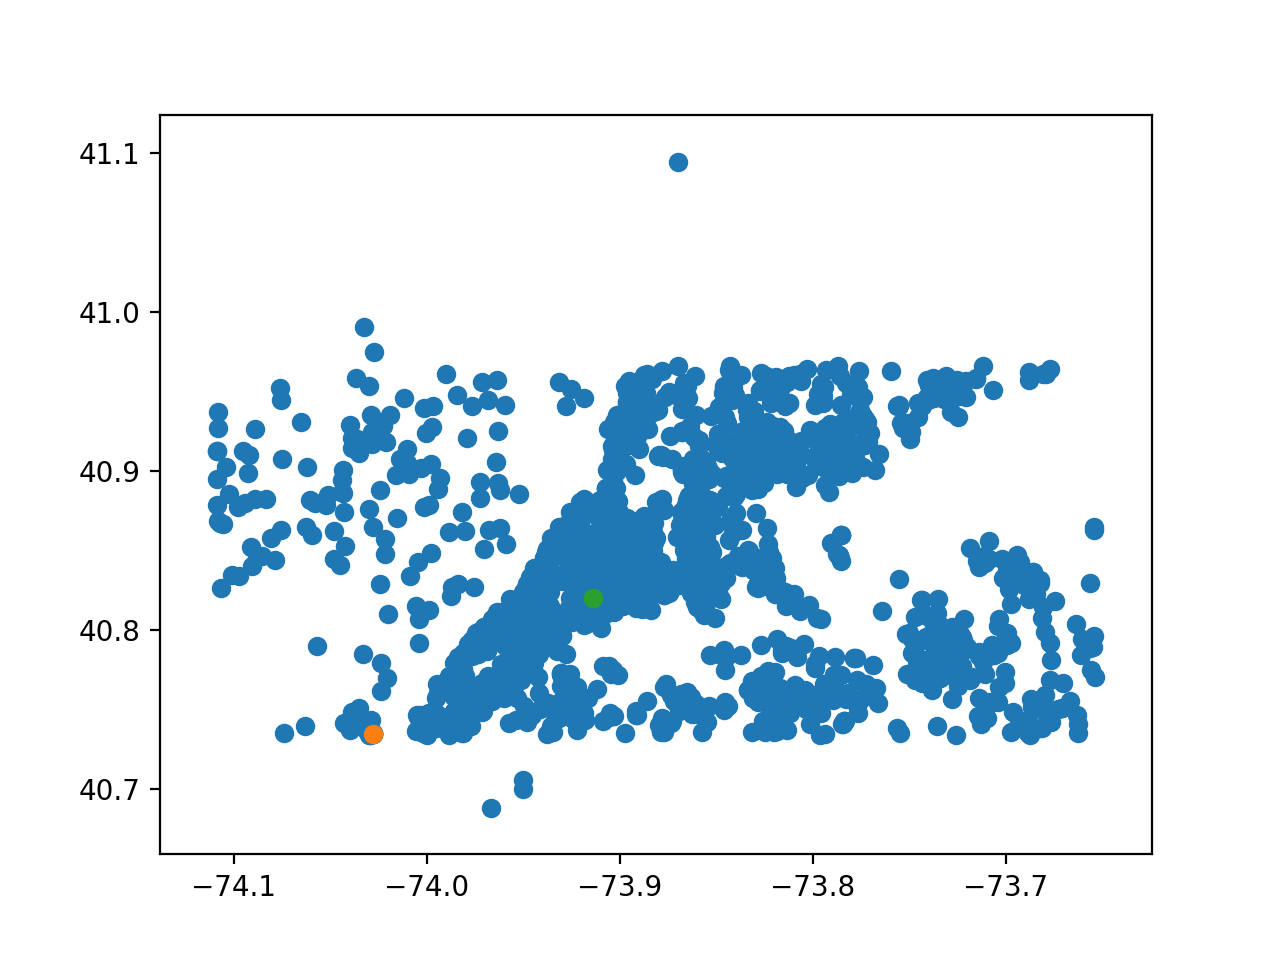

In [8]:
print(len(lats))
startindex = 0
endindex = 1000

plt.figure()
plt.scatter(lons, lats)
plt.scatter(lons[startindex], lats[startindex])
plt.scatter(lons[endindex], lats[endindex])
plt.show()


Path Length = 9


<IPython.core.display.Javascript object>


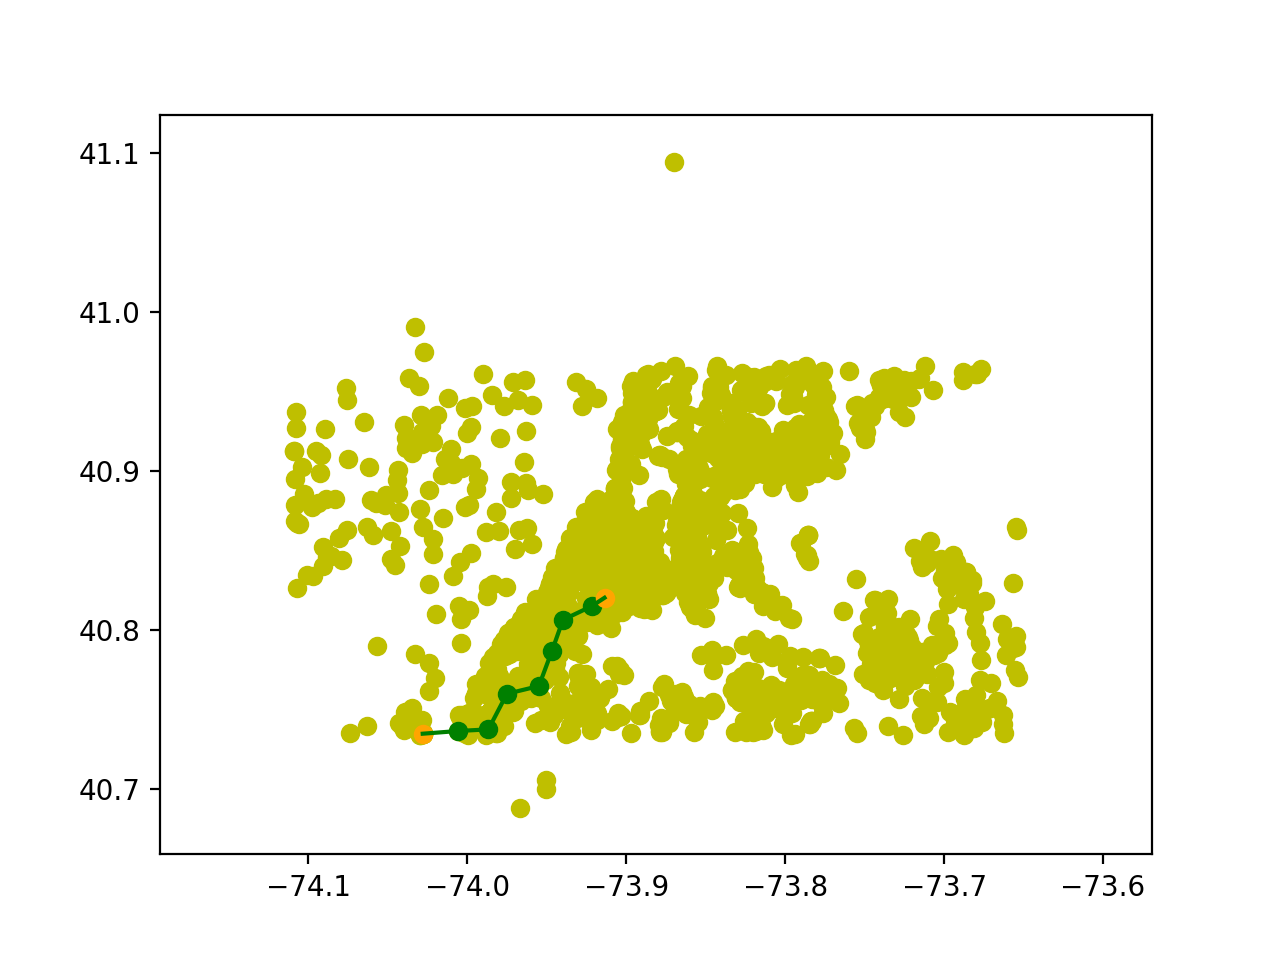

In [9]:
def asnp(x):
    return np.array(x)

z = np.concatenate([asnp(lons).reshape(-1, 1), asnp(lats).reshape(-1, 1)], axis=1)
    
path = generate_track(z=z, noise_scale=10, mindist=0.02, start_index=startindex, end_index=endindex)

visualize(z, path)